In [ ]:
#!pip install kaggle-environments -U > /dev/null 2>&1
#!cp -r ../input/lux-ai-2021/* .

In [1]:
import numpy as np
import json
from pathlib import Path
import os
import random
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pdb
import pickle

In [2]:
torch.cuda.is_available()

True

# Preprocessing

In [6]:


def to_label(action):
    strs = action.split(' ')
    unit_id = strs[1]
    if strs[0] == 'm':
        label = {'c': None, 'n': 0, 's': 1, 'w': 2, 'e': 3}[strs[2]]
    elif strs[0] == 'bcity':
        label = 4
    else:
        label = None
    return unit_id, label


def depleted_resources(obs):
    for u in obs['updates']:
        if u.split(' ')[0] == 'r':
            return False
    return True


def create_dataset_from_json(episode_dir, team_name='Toad Brigade'): 
    obses = {}
    samples = []
    append = samples.append
    episodes = [path for path in Path(episode_dir).glob('*.json') if 'output' not in path.name]
    for filepath in tqdm(episodes): 
        with open(filepath) as f:
            json_load = json.load(f)

        ep_id = json_load['info']['EpisodeId']
        

        index = np.argmax([r or 0 for r in json_load['rewards']])
        

        
        if json_load['info']['TeamNames'][index] != team_name:
            continue

        for i in range(len(json_load['steps'])-1):
            

            
            if json_load['steps'][i][index]['status'] == 'ACTIVE':
                actions = json_load['steps'][i+1][index]['action']
                obs = json_load['steps'][i][0]['observation']
                
                if depleted_resources(obs):
                    break
                
                obs['player'] = index
                obs = dict([
                    (k,v) for k,v in obs.items() 
                    if k in ['step', 'updates', 'player', 'width', 'height']
                ])
                obs_id = f'{ep_id}_{i}'
                obses[obs_id] = obs
                                
                for action in actions:
                    unit_id, label = to_label(action)
                    if label is not None:
                        append((obs_id, unit_id, label))

    return obses, samples 

In [7]:
episode_dir = 'data/archive'
obses, samples = create_dataset_from_json(episode_dir)

  0%|          | 0/467 [00:00<?, ?it/s]

In [8]:

print('obses:', len(obses), 'samples:', len(samples))

obses: 147014 samples: 988664


In [9]:
samples[71]

('28407441_35', 'u_9', 1)

In [10]:
# samples[3]
obses["28407441_35"]

{'height': 16,
 'player': 1,
 'step': 35,
 'updates': ['rp 0 10',
  'rp 1 13',
  'r coal 0 6 365',
  'r coal 0 9 365',
  'r wood 3 0 488',
  'r wood 3 3 500',
  'r wood 3 12 474',
  'r wood 3 15 342',
  'r wood 4 0 447',
  'r wood 4 3 364',
  'r wood 4 4 402',
  'r wood 4 11 361',
  'r wood 4 12 354',
  'r wood 4 15 362',
  'r uranium 6 6 306',
  'r uranium 6 7 327',
  'r uranium 6 8 327',
  'r uranium 6 9 306',
  'r uranium 7 5 348',
  'r uranium 7 6 316',
  'r uranium 7 7 337',
  'r uranium 7 8 337',
  'r uranium 7 9 316',
  'r uranium 7 10 348',
  'r coal 13 5 416',
  'r coal 13 6 424',
  'r coal 13 9 424',
  'r coal 13 10 416',
  'r wood 14 0 500',
  'r coal 14 5 361',
  'r coal 14 6 378',
  'r coal 14 9 378',
  'r coal 14 10 361',
  'r wood 14 15 500',
  'r wood 15 0 500',
  'r wood 15 15 500',
  'u 0 0 u_1 6 12 0 80 0 0',
  'u 0 0 u_3 4 2 0 0 0 0',
  'u 0 0 u_7 4 5 0 96 0 0',
  'u 0 0 u_8 3 9 1 80 0 0',
  'u 0 0 u_11 11 3 0 80 0 0',
  'u 0 0 u_12 4 1 0 0 0 0',
  'u 0 0 u_14 5 4 0

In [11]:
#('28407441_35', 'u_9', 1)
def prep (obs, unit_id ):
    width, height = obs['width'], obs['height']
    x_shift = (32 - width) // 2
    y_shift = (32 - height) // 2
    for update in obs['updates']:
        strs = update.split(' ')
        if strs[0] == 'u' and unit_id[1] == strs[3]:
            # Position and Cargo
            x = int(strs[4]) + x_shift
            y = int(strs[5]) + y_shift
            wood = int(strs[7])
            coal = int(strs[8])
            uranium = int(strs[9])
            return  (unit_id[0],unit_id[1] ,x,y, (1,(wood + coal + uranium) / 100), unit_id[2] )
             
    
sam=[]
for i in tqdm(samples):
    sam.append(prep(obses[i[0]], i))

samples[71]

  0%|          | 0/988664 [00:00<?, ?it/s]

('28407441_35', 'u_9', 1)

In [12]:
sam[71]

('28407441_35', 'u_9', 12, 21, (1, 0.0), 1)

In [13]:
def resorse_light(data, x_shift, y_shift):
    resorse=[ i.split() for i in data["updates"] if i.split()[0]=="r" ]

    resorse_point={}
    vfunc = np.vectorize(lambda x:int(x))
    resorse_point["wood"]=    np.array([ i[2:] for i in resorse if i[1]=="wood"  ])
    resorse_point["coal"]=    np.array([ i[2:] for i in resorse if i[1]=="coal"  ])
    resorse_point["uranium"]= np.array([ i[2:] for i in resorse if i[1]=="uranium"])
    for i in resorse_point:
        try:
            resorse_point[i]=vfunc(resorse_point[i])
        except:
            pass


    resorse=np.zeros((3,32,32),dtype=np.float32)
    for ind, r in enumerate(resorse_point):
        if len(resorse_point[r])==0:
              continue
        for i in range(data["width"]):
              for j in range(data["width"]):
                    resorse[ind,i+x_shift,j+y_shift]= sum(resorse_point[r][:,2]/( np.abs(resorse_point[r][:,0]-i)+np.abs(resorse_point[r][:,1]-j)+0.3))

    return resorse/(np.max(resorse,axis=(1,2)).reshape((3, 1,1))+0.01)

def make_input(obs):
    width, height = obs['width'], obs['height']
    x_shift = (32 - width) // 2
    y_shift = (32 - height) // 2
    cities = {}
    
    b = np.zeros((20, 32, 32), dtype=np.float32)
    
    for update in obs['updates']:
        strs = update.split(' ')
        input_identifier = strs[0]
        
        if input_identifier == 'u':
            x = int(strs[4]) + x_shift
            y = int(strs[5]) + y_shift
            wood = int(strs[7])
            coal = int(strs[8])
            uranium = int(strs[9])
          
            # Units
            team = int(strs[2])
            cooldown = float(strs[6])
            idx = 2 + (team - obs['player']) % 2 * 3
            b[idx:idx + 3, x, y] = (
                1,
                cooldown / 6,
                (wood + coal + uranium) / 100
            )
        elif input_identifier == 'ct':
            # CityTiles
            team = int(strs[1])
            city_id = strs[2]
            x = int(strs[3]) + x_shift
            y = int(strs[4]) + y_shift
            idx = 8 + (team - obs['player']) % 2 * 2
            b[idx:idx + 2, x, y] = (
                1,
                cities[city_id]
            )
        
        elif input_identifier == 'rp':
            # Research Points
            team = int(strs[1])
            rp = int(strs[2])
            b[15 + (team - obs['player']) % 2, :] = min(rp, 200) / 200
        elif input_identifier == 'c':
            # Cities
            city_id = strs[2]
            fuel = float(strs[3])
            lightupkeep = float(strs[4])
            cities[city_id] = min(fuel / lightupkeep, 10) / 10
    
    # Day/Night Cycle
    b[17, :] = obs['step'] % 40 / 40
    # Turns
    b[18, :] = obs['step'] / 360
    # Map Size
    b[19, x_shift:32 - x_shift, y_shift:32 - y_shift] = 1
   
    b[12:15]= resorse_light(obs, x_shift, y_shift)
        
    return b 


In [14]:
exemple=make_input(obses["28407441_35"])

<AxesSubplot:>

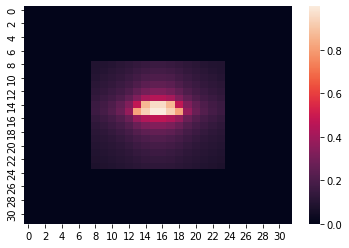

In [15]:
import seaborn as sns
sns.heatmap(exemple[14])

In [25]:
dict_sample={}
for i in tqdm(sam):
    try:
        dict_sample[i[0]].append(i)
    except:
        dict_sample[i[0]]=[]
        dict_sample[i[0]].append(i) 
           

  0%|          | 0/988664 [00:00<?, ?it/s]

In [26]:
!mkdir preprocesing_data

mkdir: cannot create directory ‘preprocesing_data’: File exists


In [27]:
dir_="preprocesing_data"
splits = np.array_split(list(obses.keys()), 15)

for index, batch in enumerate(splits):
    count_samples=0
    count_batch=0
    data={}
    for key in tqdm(batch):
        
        obs=make_input(obses[key])
        try:
            data[key]= {"obses":obs,"samples":dict_sample[key]}
            count_samples+=len(dict_sample[key])
            count_batch+=1
        except KeyError:
            pass   
    if  count_samples>0:     
        with open(f"{dir_}/file_data_{index}.pickle", 'wb') as f:
                pickle.dump({'samples':count_samples ,'obses':count_batch }, f) 
                pickle.dump(data, f) 

            
  

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9801 [00:00<?, ?it/s]

  0%|          | 0/9800 [00:00<?, ?it/s]

In [28]:
import pickle
dir_="preprocesing_data"
def Lengs_data(path_folder):
        episodes = [path for path in Path(path_folder).glob('*data*.pickle') ] 
        d={'samples':0, 'obses':0}
        total={}
        for i in episodes:
            with open(i, 'rb') as f:
                a = pickle.load(f) 
                d['samples']+=a["samples"]
                d['obses']+=a["obses"] 
                print( i, " sample ",a["samples"], " obses ", a["obses"]   )
                a = pickle.load(f)
                obs=len(a)
                sam=0
              
                for i2 in a:
                    sam+=len(a[i2]["samples"])
                  
                print( i, " sample_real ", sam, " obses_real ", obs  )
                    
                
                
        return d

In [29]:
Lengs_data(dir_)

preprocesing_data/file_data_0.pickle  sample  65479  obses  9014
preprocesing_data/file_data_0.pickle  sample_real  65479  obses_real  9014
preprocesing_data/file_data_1.pickle  sample  80374  obses  9182
preprocesing_data/file_data_1.pickle  sample_real  80374  obses_real  9182
preprocesing_data/file_data_10.pickle  sample  56451  obses  8920
preprocesing_data/file_data_10.pickle  sample_real  56451  obses_real  8920
preprocesing_data/file_data_11.pickle  sample  71036  obses  8938
preprocesing_data/file_data_11.pickle  sample_real  71036  obses_real  8938
preprocesing_data/file_data_12.pickle  sample  53398  obses  8825
preprocesing_data/file_data_12.pickle  sample_real  53398  obses_real  8825
preprocesing_data/file_data_13.pickle  sample  62882  obses  8795
preprocesing_data/file_data_13.pickle  sample_real  62882  obses_real  8795
preprocesing_data/file_data_14.pickle  sample  68039  obses  8891
preprocesing_data/file_data_14.pickle  sample_real  68039  obses_real  8891
preprocesi

{'samples': 988664, 'obses': 134328}

In [34]:

import os 
class LuxDataset_NEW(Dataset):
    
    def Lengs_data(self,path_folder):
        episodes = [path for path in Path(path_folder).glob('*data*.pickle') ] 
        d={'samples':0, 'obses':0}
        for i in episodes:
            with open(i, 'rb') as f:
                a = pickle.load(f) 
                d['samples']+=a["samples"]
                d['obses']+=a["obses"]       
        return d
    
    
    
    def prepear_temp(self): # temorary folder 
        episodes = [path for path in (self.path_streem_data  ).glob('*data*.pickle') ]
        lens_data=0
        rr=0
        for filepath in tqdm(episodes):
            pic_0={} 
            with open(filepath, 'rb') as f:
                pickle.load(f)
                while True:    
                    try:
                        pic_0.update( pickle.load(f))
                    except:
                        break
            with open(self.path_streem_data/"temp"/filepath.name, "wb") as f:
                pickle.dump(pic_0, f) 
   
    def read_picl(self,path):# read pickle
        pic_0={} 
        with open(path, 'rb') as f:
            
            while True:    
                try:
                    pic_0.update( pickle.load(f))


                except:
                    break
        return pic_0    
    
    
    def write (self,pic_0):
        def write_data (data , path):
            with open(path, "ab") as f:
                pickle.dump(data, f) 

        import numpy as np
        shufle=np.array(list(pic_0.keys()))
        np.random.shuffle(shufle)
        vfunc = np.vectorize(lambda x:int(x))
        lin=vfunc(np.linspace(0, len(pic_0),14))

        for i , v in enumerate(lin[:-1]):
            pc_temp={}
            for j in shufle[v:lin[i+1]]:
                pc_temp[j]=pic_0[j]
            write_data(pc_temp , self.path_streem_data / "temp" / ("data" +self.pref[self.shift_ind]+"_"+str(i)+".pickle"))
    
    def sufle_sample(self):
        shafle=[]
        for i in self.data:
          
            shafle+=self.data[i]["samples"]
        np.random.shuffle(shafle)    
        self.shufle=shafle
       
    
    def Update_data(self):
        if len(self.episodes)!=0:
           # print(self.episodes)
            data=self.read_picl(self.episodes[0])
            
            self.write(data)
            self.data=data
            os.remove(self.episodes[0])
            self.episodes=self.episodes[1:]
           # print(self.episodes)
            self.sufle_sample()
        else:
            self.shift_ind=(1+self.shift_ind)%2
            self.episodes = [path for path in (self.path_streem_data/"temp").glob('data*.pickle') ]
            self.Update_data()
        
    
    def __init__(self, path_streem_data):
        
        self.path_streem_data=Path(path_streem_data)
        self.len_data= self.Lengs_data(path_streem_data)
        try :
            import shutil

            shutil.rmtree(self.path_streem_data/"temp")
            
        except:
            pass
        os.mkdir(self.path_streem_data/"temp")
        self.prepear_temp()
        self.episodes = [path for path in (self.path_streem_data/"temp").glob('*data*.pickle') ]
        self.cheredovat_ind=0
        self.pref=["A",""]
        
        self.shift_ind=0
        
        self.shift_ind_data=0
        self.Update_data()
        self.test_indek_kepper=[]
        
        
    def __len__(self):
        return self.len_data["samples"]

    def __getitem__(self, idx):
        
        if idx == len(self):
            raise IndexError
        if (idx>=len(self.shufle)+self.shift_ind_data) or idx<self.shift_ind_data:
            self.shift_ind_data=idx
          
            self.Update_data()
    
            
        
        sample = self.shufle[idx-self.shift_ind_data]
        state  = self.data[sample[0]]["obses"]
        
        state[:2, sample[2], sample[3]] = sample[4]
       # [('29239603_358', 'u_17', 9, 5, (1, 0.96), 2)]
        
        return state[:20], sample[5]

In [66]:
class data_loder_my():
    def __init__(self,dataset,bach_size):
        self.dataset=dataset
        self.bach_size=bach_size
    def __len__(self):
        return len( self.dataset)//self.bach_size
    def __getitem__(self, items):
        bach_x=[]
        bach_y=[]
        for i in range(self.bach_size):
            x,y=self.dataset[items*self.bach_size +i]
            bach_x.append(x)
            bach_y.append(y)
        return torch.from_numpy(np.array(bach_x)), torch.from_numpy(np.array(bach_y))   
    
    

In [69]:
class LuxDataset_NEW_VAL(Dataset):
    
    def Lengs_data(self,path_folder):
        a=0
        with open(path_folder, 'rb') as f:
            a = pickle.load(f) 
                
        return a

    def read_picl(self,path):# read pickle
        pic_0={} 
        with open(path, 'rb') as f:
            pickle.load(f)
            while True:    
                try:
                    pic_0.update( pickle.load(f))


                except:
                    break
        return pic_0    
    
    def sufle_sample(self):
        shafle=[]
        for i in self.data:
            shafle+=self.data[i]["samples"]
    
        self.shufle=shafle
        
    def __init__(self, path_streem_data):
        self.len_data=self.Lengs_data(path_streem_data)
        self.data=self.read_picl(path_streem_data)
        self.sufle_sample()
        
        
        
        
    def __len__(self):
        return self.len_data["samples"]

    def __getitem__(self, idx):
        
        if idx == len(self):
            raise IndexError
       
        sample = self.shufle[idx]
        state  = self.data[sample[0]]["obses"]
        
        state[:2, sample[2], sample[3]] = sample[4]
       # [('29239603_358', 'u_17', 9, 5, (1, 0.96), 2)]
        
        return state[:20], sample[5]

In [35]:
dataset_test= LuxDataset_NEW(Path(dir_) )

  0%|          | 0/15 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/file_data_1.pickle'), PosixPath('preprocesing_data/temp/file_data_10.pickle'), PosixPath('preprocesing_data/temp/file_data_11.pickle'), PosixPath('preprocesing_data/temp/file_data_12.pickle'), PosixPath('preprocesing_data/temp/file_data_13.pickle'), PosixPath('preprocesing_data/temp/file_data_14.pickle'), PosixPath('preprocesing_data/temp/file_data_2.pickle'), PosixPath('preprocesing_data/temp/file_data_3.pickle'), PosixPath('preprocesing_data/temp/file_data_4.pickle'), PosixPath('preprocesing_data/temp/file_data_5.pickle'), PosixPath('preprocesing_data/temp/file_data_6.pickle'), PosixPath('preprocesing_data/temp/file_data_7.pickle'), PosixPath('preprocesing_data/temp/file_data_8.pickle'), PosixPath('preprocesing_data/temp/file_data_9.pickle')]


In [76]:
obs,sample=dataset_test[10]

In [82]:
dataset_test.shufle[:10]

[('28414706_245', 'u_47', 9, 11, (1, 1.0), 1),
 ('28412606_67', 'u_19', 30, 24, (1, 1.0), 1),
 ('28413179_182', 'u_31', 20, 14, (1, 0.0), 1),
 ('28414324_174', 'u_75', 12, 15, (1, 0.0), 2),
 ('28413372_142', 'u_47', 12, 4, (1, 0.6), 2),
 ('28414324_29', 'u_6', 9, 8, (1, 1.0), 4),
 ('28415088_133', 'u_3', 11, 11, (1, 0.0), 2),
 ('28411641_202', 'u_39', 13, 5, (1, 0.0), 3),
 ('28412035_281', 'u_70', 11, 10, (1, 0.0), 0),
 ('28409735_50', 'u_11', 7, 16, (1, 1.0), 4)]

<AxesSubplot:>

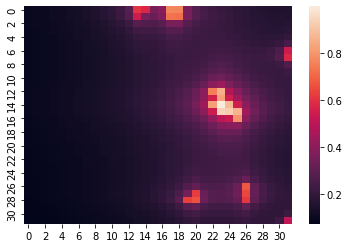

In [94]:
sns.heatmap(obs[12])

In [64]:
# Neural Network for Lux AI
class BasicConv2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, bn):
        super().__init__()
        self.conv = nn.Conv2d(
            input_dim, output_dim, 
            kernel_size=kernel_size, 
            padding=(kernel_size[0] // 2, kernel_size[1] // 2)
        )
        self.bn = nn.BatchNorm2d(output_dim) if bn else None
      

    def forward(self, x):
        h = self.conv(x)
        h = self.bn(h) if self.bn is not None else h
        
        return h


class LuxNet(nn.Module):
    def __init__(self):
        super().__init__()
        layers, filters = 12, 32
        self.conv0 = BasicConv2d(20, filters, (3, 3), True)
        self.blocks = nn.ModuleList([BasicConv2d(filters, filters, (3, 3), True) for _ in range(layers)])
        
        self.drop = nn.Dropout(p=0.2)
        self.head_p = nn.Linear(filters, 5, bias=False)

    def forward(self, x):
        h = F.relu_(self.conv0(x))
        for block in self.blocks:
            h = F.relu_(h + block(h))
        h_head = (h * x[:,:1]).view(h.size(0), h.size(1), -1).sum(-1)
        h_head=self.drop(h_head)
        p = self.head_p(h_head)
        return p

In [73]:
model = LuxNet()


batch_size = 64

train_loader=data_loder_my(LuxDataset_NEW(Path(dir_) ),batch_size)

val_loader = DataLoader(
    LuxDataset_NEW_VAL(Path("preprocesing_data/validate/file_data_0.pickle")), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=1
)
dataloaders_dict = {"train": train_loader, "val": val_loader}
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

  0%|          | 0/14 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/file_data_10.pickle'), PosixPath('preprocesing_data/temp/file_data_11.pickle'), PosixPath('preprocesing_data/temp/file_data_12.pickle'), PosixPath('preprocesing_data/temp/file_data_13.pickle'), PosixPath('preprocesing_data/temp/file_data_14.pickle'), PosixPath('preprocesing_data/temp/file_data_2.pickle'), PosixPath('preprocesing_data/temp/file_data_3.pickle'), PosixPath('preprocesing_data/temp/file_data_4.pickle'), PosixPath('preprocesing_data/temp/file_data_5.pickle'), PosixPath('preprocesing_data/temp/file_data_6.pickle'), PosixPath('preprocesing_data/temp/file_data_7.pickle'), PosixPath('preprocesing_data/temp/file_data_8.pickle'), PosixPath('preprocesing_data/temp/file_data_9.pickle')]


In [74]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.cuda()
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_acc = 0
            
            dataloader = dataloaders_dict[phase]
            for item in tqdm(dataloader, leave=False):
                states = item[0].cuda().float()
                actions = item[1].cuda().long()
               
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    policy = model(states)
                    loss = criterion(policy, actions)
                    _, preds = torch.max(policy, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * len(policy)
                    epoch_acc += torch.sum(preds == actions.data)

            data_size = len(dataloader.dataset)
            epoch_loss = epoch_loss / data_size
            epoch_acc = epoch_acc.double() / data_size

            print(f'Epoch {epoch + 1}/{num_epochs} | {phase:^5} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            traced = torch.jit.trace(model.cpu(), torch.rand(1, 20, 32, 32))
            traced.save('model_drop.pth')
            best_acc = epoch_acc

In [206]:
len(train_loader.dataset)

172179

In [73]:
len(train_loader.dataset)

172179

In [75]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=2)

  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/file_data_11.pickle'), PosixPath('preprocesing_data/temp/file_data_12.pickle'), PosixPath('preprocesing_data/temp/file_data_13.pickle'), PosixPath('preprocesing_data/temp/file_data_14.pickle'), PosixPath('preprocesing_data/temp/file_data_2.pickle'), PosixPath('preprocesing_data/temp/file_data_3.pickle'), PosixPath('preprocesing_data/temp/file_data_4.pickle'), PosixPath('preprocesing_data/temp/file_data_5.pickle'), PosixPath('preprocesing_data/temp/file_data_6.pickle'), PosixPath('preprocesing_data/temp/file_data_7.pickle'), PosixPath('preprocesing_data/temp/file_data_8.pickle'), PosixPath('preprocesing_data/temp/file_data_9.pickle')]
[PosixPath('preprocesing_data/temp/file_data_12.pickle'), PosixPath('preprocesing_data/temp/file_data_13.pickle'), PosixPath('preprocesing_data/temp/file_data_14.pickle'), PosixPath('preprocesing_data/temp/file_data_2.pickle'), PosixPath('preprocesing_data/temp/file_data_3.pickle'), PosixPath('preprocesing_data/temp/file_

  0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 1/5 |  val  | Loss: 1.4665 | Acc: 0.3555


  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/dataA_1.pickle'), PosixPath('preprocesing_data/temp/dataA_10.pickle'), PosixPath('preprocesing_data/temp/dataA_11.pickle'), PosixPath('preprocesing_data/temp/dataA_12.pickle'), PosixPath('preprocesing_data/temp/dataA_2.pickle'), PosixPath('preprocesing_data/temp/dataA_3.pickle'), PosixPath('preprocesing_data/temp/dataA_4.pickle'), PosixPath('preprocesing_data/temp/dataA_5.pickle'), PosixPath('preprocesing_data/temp/dataA_6.pickle'), PosixPath('preprocesing_data/temp/dataA_7.pickle'), PosixPath('preprocesing_data/temp/dataA_8.pickle'), PosixPath('preprocesing_data/temp/dataA_9.pickle')]
[PosixPath('preprocesing_data/temp/dataA_10.pickle'), PosixPath('preprocesing_data/temp/dataA_11.pickle'), PosixPath('preprocesing_data/temp/dataA_12.pickle'), PosixPath('preprocesing_data/temp/dataA_2.pickle'), PosixPath('preprocesing_data/temp/dataA_3.pickle'), PosixPath('preprocesing_data/temp/dataA_4.pickle'), PosixPath('preprocesing_data/temp/dataA_5.pickle'), Posi

  0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 2/5 |  val  | Loss: 1.4333 | Acc: 0.3706


  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/data_1.pickle'), PosixPath('preprocesing_data/temp/data_10.pickle'), PosixPath('preprocesing_data/temp/data_11.pickle'), PosixPath('preprocesing_data/temp/data_12.pickle'), PosixPath('preprocesing_data/temp/data_2.pickle'), PosixPath('preprocesing_data/temp/data_3.pickle'), PosixPath('preprocesing_data/temp/data_4.pickle'), PosixPath('preprocesing_data/temp/data_5.pickle'), PosixPath('preprocesing_data/temp/data_6.pickle'), PosixPath('preprocesing_data/temp/data_7.pickle'), PosixPath('preprocesing_data/temp/data_8.pickle'), PosixPath('preprocesing_data/temp/data_9.pickle')]
[PosixPath('preprocesing_data/temp/data_10.pickle'), PosixPath('preprocesing_data/temp/data_11.pickle'), PosixPath('preprocesing_data/temp/data_12.pickle'), PosixPath('preprocesing_data/temp/data_2.pickle'), PosixPath('preprocesing_data/temp/data_3.pickle'), PosixPath('preprocesing_data/temp/data_4.pickle'), PosixPath('preprocesing_data/temp/data_5.pickle'), PosixPath('preprocesing

  0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 3/5 |  val  | Loss: 1.4225 | Acc: 0.3721


  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/dataA_1.pickle'), PosixPath('preprocesing_data/temp/dataA_10.pickle'), PosixPath('preprocesing_data/temp/dataA_11.pickle'), PosixPath('preprocesing_data/temp/dataA_12.pickle'), PosixPath('preprocesing_data/temp/dataA_2.pickle'), PosixPath('preprocesing_data/temp/dataA_3.pickle'), PosixPath('preprocesing_data/temp/dataA_4.pickle'), PosixPath('preprocesing_data/temp/dataA_5.pickle'), PosixPath('preprocesing_data/temp/dataA_6.pickle'), PosixPath('preprocesing_data/temp/dataA_7.pickle'), PosixPath('preprocesing_data/temp/dataA_8.pickle'), PosixPath('preprocesing_data/temp/dataA_9.pickle')]
[PosixPath('preprocesing_data/temp/dataA_10.pickle'), PosixPath('preprocesing_data/temp/dataA_11.pickle'), PosixPath('preprocesing_data/temp/dataA_12.pickle'), PosixPath('preprocesing_data/temp/dataA_2.pickle'), PosixPath('preprocesing_data/temp/dataA_3.pickle'), PosixPath('preprocesing_data/temp/dataA_4.pickle'), PosixPath('preprocesing_data/temp/dataA_5.pickle'), Posi

  0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 4/5 |  val  | Loss: 1.4240 | Acc: 0.3705


  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/data_1.pickle'), PosixPath('preprocesing_data/temp/data_10.pickle'), PosixPath('preprocesing_data/temp/data_11.pickle'), PosixPath('preprocesing_data/temp/data_12.pickle'), PosixPath('preprocesing_data/temp/data_2.pickle'), PosixPath('preprocesing_data/temp/data_3.pickle'), PosixPath('preprocesing_data/temp/data_4.pickle'), PosixPath('preprocesing_data/temp/data_5.pickle'), PosixPath('preprocesing_data/temp/data_6.pickle'), PosixPath('preprocesing_data/temp/data_7.pickle'), PosixPath('preprocesing_data/temp/data_8.pickle'), PosixPath('preprocesing_data/temp/data_9.pickle')]
[PosixPath('preprocesing_data/temp/data_10.pickle'), PosixPath('preprocesing_data/temp/data_11.pickle'), PosixPath('preprocesing_data/temp/data_12.pickle'), PosixPath('preprocesing_data/temp/data_2.pickle'), PosixPath('preprocesing_data/temp/data_3.pickle'), PosixPath('preprocesing_data/temp/data_4.pickle'), PosixPath('preprocesing_data/temp/data_5.pickle'), PosixPath('preprocesing

  0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 5/5 |  val  | Loss: 1.4190 | Acc: 0.3772


  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/dataA_1.pickle'), PosixPath('preprocesing_data/temp/dataA_10.pickle'), PosixPath('preprocesing_data/temp/dataA_11.pickle'), PosixPath('preprocesing_data/temp/dataA_12.pickle'), PosixPath('preprocesing_data/temp/dataA_2.pickle'), PosixPath('preprocesing_data/temp/dataA_3.pickle'), PosixPath('preprocesing_data/temp/dataA_4.pickle'), PosixPath('preprocesing_data/temp/dataA_5.pickle'), PosixPath('preprocesing_data/temp/dataA_6.pickle'), PosixPath('preprocesing_data/temp/dataA_7.pickle'), PosixPath('preprocesing_data/temp/dataA_8.pickle'), PosixPath('preprocesing_data/temp/dataA_9.pickle')]
[PosixPath('preprocesing_data/temp/dataA_10.pickle'), PosixPath('preprocesing_data/temp/dataA_11.pickle'), PosixPath('preprocesing_data/temp/dataA_12.pickle'), PosixPath('preprocesing_data/temp/dataA_2.pickle'), PosixPath('preprocesing_data/temp/dataA_3.pickle'), PosixPath('preprocesing_data/temp/dataA_4.pickle'), PosixPath('preprocesing_data/temp/dataA_5.pickle'), Posi

  0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 1/5 |  val  | Loss: 1.3984 | Acc: 0.3847


  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/data_1.pickle'), PosixPath('preprocesing_data/temp/data_10.pickle'), PosixPath('preprocesing_data/temp/data_11.pickle'), PosixPath('preprocesing_data/temp/data_12.pickle'), PosixPath('preprocesing_data/temp/data_2.pickle'), PosixPath('preprocesing_data/temp/data_3.pickle'), PosixPath('preprocesing_data/temp/data_4.pickle'), PosixPath('preprocesing_data/temp/data_5.pickle'), PosixPath('preprocesing_data/temp/data_6.pickle'), PosixPath('preprocesing_data/temp/data_7.pickle'), PosixPath('preprocesing_data/temp/data_8.pickle'), PosixPath('preprocesing_data/temp/data_9.pickle')]
[PosixPath('preprocesing_data/temp/data_10.pickle'), PosixPath('preprocesing_data/temp/data_11.pickle'), PosixPath('preprocesing_data/temp/data_12.pickle'), PosixPath('preprocesing_data/temp/data_2.pickle'), PosixPath('preprocesing_data/temp/data_3.pickle'), PosixPath('preprocesing_data/temp/data_4.pickle'), PosixPath('preprocesing_data/temp/data_5.pickle'), PosixPath('preprocesing

  0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 2/5 |  val  | Loss: 1.3971 | Acc: 0.3833


  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/dataA_1.pickle'), PosixPath('preprocesing_data/temp/dataA_10.pickle'), PosixPath('preprocesing_data/temp/dataA_11.pickle'), PosixPath('preprocesing_data/temp/dataA_12.pickle'), PosixPath('preprocesing_data/temp/dataA_2.pickle'), PosixPath('preprocesing_data/temp/dataA_3.pickle'), PosixPath('preprocesing_data/temp/dataA_4.pickle'), PosixPath('preprocesing_data/temp/dataA_5.pickle'), PosixPath('preprocesing_data/temp/dataA_6.pickle'), PosixPath('preprocesing_data/temp/dataA_7.pickle'), PosixPath('preprocesing_data/temp/dataA_8.pickle'), PosixPath('preprocesing_data/temp/dataA_9.pickle')]
[PosixPath('preprocesing_data/temp/dataA_10.pickle'), PosixPath('preprocesing_data/temp/dataA_11.pickle'), PosixPath('preprocesing_data/temp/dataA_12.pickle'), PosixPath('preprocesing_data/temp/dataA_2.pickle'), PosixPath('preprocesing_data/temp/dataA_3.pickle'), PosixPath('preprocesing_data/temp/dataA_4.pickle'), PosixPath('preprocesing_data/temp/dataA_5.pickle'), Posi

  0%|          | 0/1024 [00:00<?, ?it/s]

Epoch 3/5 |  val  | Loss: 1.3959 | Acc: 0.3841


  0%|          | 0/14424 [00:00<?, ?it/s]

[PosixPath('preprocesing_data/temp/data_1.pickle'), PosixPath('preprocesing_data/temp/data_10.pickle'), PosixPath('preprocesing_data/temp/data_11.pickle'), PosixPath('preprocesing_data/temp/data_12.pickle'), PosixPath('preprocesing_data/temp/data_2.pickle'), PosixPath('preprocesing_data/temp/data_3.pickle'), PosixPath('preprocesing_data/temp/data_4.pickle'), PosixPath('preprocesing_data/temp/data_5.pickle'), PosixPath('preprocesing_data/temp/data_6.pickle'), PosixPath('preprocesing_data/temp/data_7.pickle'), PosixPath('preprocesing_data/temp/data_8.pickle'), PosixPath('preprocesing_data/temp/data_9.pickle')]


KeyboardInterrupt: 

# Cheak Dummy



In [97]:
labels={ 0:'n', 1: 's', 2: 'w', 3: 'e', 4:"build"}
labels_count={ 0:0, 1:0, 2: 0, 3: 0, 4:0}


for action in dataset_test.shufle:
    labels_count[action[-1]]+=1
    

In [100]:
for i in labels_count:
    labels_count[i]/=len(dataset_test.shufle)

In [106]:
for action in labels_count:
    print(f"{labels[action]}: {round(labels_count[action],2)}%")

n: 0.28%
s: 0.25%
w: 0.19%
e: 0.19%
build: 0.09%
